# GPyOpt: The tool for Bayesian Optimization 

### Written by Javier Gonzalez (j.h.gonzalez@sheffield.ac.uk), University of Sheffield.

## Reference Manual index

=====================================================================================================
1. **What is GPyOpt?**

2. **How to install GPyopt?**

3. **How to use GPyOpt?**
    1. Gaussian Processes
    2. Acquisition functions
    3. Applications of Bayesian Optimization 

4. **The Basics of Bayesian Optimization**

5. **1D optimization example**

6. **2D optimization example**

=====================================================================================================

## 1. What is GPyOpt?

GPyOpt (http://sheffieldml.github.io/GPy/) is a tool for optimization (minimization) of black-box functions using Gaussian processes. It is based on GPy (http://sheffieldml.github.io/GPy/) and it has been implemented in Python 2.7 (https://www.python.org/download/releases/2.7/) by the group of Machine Learning (at SITraN) of the University of Sheffield (http://ml.dcs.shef.ac.uk/sitran/). 

These are the main features of GPyOpt:

* You can perform Bayesian Optimization with **most common acquisition functions**, such as  Expected improvement (EI), Maximum probability of improvement (MPI) or the Upper confidence bound (GP-UCB, called LCB in GPyOpt since it performs minimization).


* **Any model available in GPy can used in GPyOpt** as a surrogate of the function to optimize. This includes a wide variety of kernel functions (and kernel combinations) and models such as Sparse Gaussian process, useful to speed up computational costs in large scale scenarios. See GPy  https://gpy.readthedocs.org/en/latest/ for details. 


* GPyOpt allows you to run **parallel Bayesian optimization**. This is helpful when you want to perform simultaneously several evaluations of the function that you want to optimize.


* You can use GPyOpt to **design physical experiments**. If you are or if you work with a wetlab person you can use GPyOpt to determine optimal strategies for sequential experimental designs. 


* GPyOpt contains a repository of **test functions for optimization ** and several **demos** you can run.

=====================================================================================================


## 2. How to install GPyOPt?

The simplest way to install GPyOpt is using pip. Ubuntu users can do:

```
sudo apt-get install python-pip
pip install gpyopt
```    
=====================================================================================================

## 3. How to use GPyOpt?

In [1]:
%pylab inline  
import GPy
import GPyOpt
from numpy.random import seed
seed(12345)

Populating the interactive namespace from numpy and matplotlib


GPyOpt is easy to use as a black-box functions optimizer. To start you only need: 

* Your favorite function $f$ to minimize. We use $f(x)=2x^2$ in this toy example, whose global minimum is at x=0.

In [3]:
def myf(x):
    return (2*x)**2

* A set of box constrains, the interval [-1,1] in our case.

In [4]:
bounds = [(-1,1)]

* A budget, or number of allowed evaluations of $f$.

In [5]:
max_iter = 15

With this three pieces of information GPyOpt has enough to find the minimum of $f$ in the selected region. GPyOpt solves the problem in two steps. First, you need to create a GPyOpt object that stores the problem (f and and box-constrains). You can do it as follows.

In [6]:
myProblem = GPyOpt.methods.BayesianOptimization(myf,bounds)

Next you need to run the optimization for the given budget of iterations

In [7]:
myProblem.run_optimization(max_iter)

*Optimization completed:
   -Maximum number of iterations reached.


1

Now you can check the best found location $x^*$ by

In [8]:
myProblem.x_opt

array([-0.00083953])

and the predicted value value of $f$ at $x^*$ optimum by

In [9]:
myProblem.fx_opt

array([  2.81925107e-06])

And that's it! Keep reading to learn how GPyOpt uses Bayesian Optimization to solve this an other optimization problem. You will also learn all the features and options that you can use to solve your problems efficiently. 

=====================================================================================================


## 4. The Basics of Bayesian Optimization

Bayesian optimization (BO) is an strategy for global optimization of black-box functions [(Snoek et al., 2012)](http://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf). Let $f: {\mathcal X} \to R$ be a L-Lipschitz  continuous function defined on a compact subset ${\mathcal X} \subseteq R^d$. We are interested in solving the global optimization problem of finding
$$ x_{M} = \arg \min_{x \in {\mathcal X}} f(x). $$

We assume that $f$ is a *black-box* from which only perturbed evaluations of the type $y_i = f(x_i) + \epsilon_i$, with $\epsilon_i \sim\mathcal{N}(0,\psi^2)$, are  available. The goal is to make a series of $x_1,\dots,x_N$ evaluations of $f$ such that the *cumulative regret* 
$$r_N= Nf(x_{M})- \sum_{n=1}^N f(x_n),$$ 
is minimized. Essentially, $r_N$ is minimized if we start evaluating $f$ at $x_{M}$ as soon as possible. 

There are two crucial bits in any Bayesian Optimization (BO) procedure approach.

1. Define a **prior probability measure** on $f$: this function will capture the our prior beliefs on $f$. The prior will be updated to a 'posterior' using the available data.

2. Define an **acquisition function** $acqu(x)$: this is a criteria to decide where to sample next in order to gain the maximum information about the location of the global maximum of $f$.

Every time a new data point is collected. The model is re-estimated and the acquisition function optimized again until convergence. Given a prior over the function $f$ and an acquisition function, a BO procedure will converge to the optimum of $f$ under some conditions [(Bull, 2011)](http://arxiv.org/pdf/1101.3501.pdf).

### 4.1 Prior probability meassure on $f$: Gaussian processes

A Gaussian process (GP) is a probability distribution across classes functions, typically smooth, such that each linear finite-dimensional restriction is multivariate Gaussian [(Rasmussen and Williams, 2006)](http://www.gaussianprocess.org/gpml). GPs are fully parametrized by a mean $\mu(x)$ and a covariance function $k(x,x')$.  Without loss of generality $\mu(x)$ is assumed to be zero. The covariance function $k(x,x')$ characterizes the smoothness and other properties of $f$. It is known as the
kernel of the process and has to be continuous, symmetric and positive definite. A widely used kernel is the square exponential, given by

$$ k(x,x') = l \cdot \exp{ \left(-\frac{\|x-x'\|^2}{2\sigma^2}\right)} $$
where $\sigma^2$ and and $l$ are positive parameters. 

To denote that $f$ is a sample from a GP with mean $\mu$ and covariance $k$ we write 

$$f(x) \sim \mathcal{GP}(\mu(x),k(x,x')).$$ 

For regression tasks, the most important feature of GPs is that process priors are conjugate to the likelihood from finitely many observations $y= (y_1,\dots,y_n)^T$ and $X =\{x_1,...,x_n\}$, $x_i\in \mathcal{X}$ of the form $y_i = f(x_i) + \epsilon_i $
where $\epsilon_i \sim \mathcal{N} (0,\sigma^2)$. We obtain the Gaussian posterior posterior $f(x^*)|X, y, \theta \sim \mathcal{N}(\mu(x^*),\sigma^2(x^*))$, where $\mu(x^*)$ and $\sigma^2(x^*)$ have close form. See [(Rasmussen and Williams, 2006)](http://www.gaussianprocess.org/gpml) for details.

### 4.2 Acquisition Function

Acquisition functions are designed represents our beliefs over the maximum of $f(x)$. Denote by $\theta$ the parameters of the GP model and by $\{x_i,y_i\}$ the available sample. Three of the most common acquisition functions, all available in GPyOpt are:

* **Maximum probability of improvement (MPI)**:

$$acqu_{MPI}(x;\{x_n,y_n\},\theta) = \Phi(\gamma(x)), \mbox{where}\   \gamma(x)=\frac{\mu(x;\{x_n,y_n\},\theta)-f(x_{best})-\psi}{\sigma(x;\{x_n,y_n\},\theta)}.$$


* **Expected improvement (EI)**:

$$acqu_{EI}(x;\{x_n,y_n\},\theta) = \sigma(x;\{x_n,y_n\},\theta) (\gamma(x) \Phi(\gamma(x))) + N(\gamma(x);0,1).$$

* **Upper confidence bound (UCB)**:

$$acqu_{UCB}(x;\{x_n,y_n\},\theta) = -\mu(x;\{x_n,y_n\},\theta)+\psi\sigma(x;\{x_n,y_n\},\theta).$$

$\psi$ is a tunable parameters that help to make the acquisition functions more flexible. Also, in the case of the UBC, the parameter $\eta$ is useful to define the balance between the importance we give to the mean and the variance of the model. This is know as the **exploration/exploitation trade off**.

### 4.3 Applications of Bayesian Optimization

Bayesian Optimization has been applied to solve a wide range of problems. Among many other, some nice applications of Bayesian Optimization include: 


* Sensor networks (http://www.robots.ox.ac.uk/~parg/pubs/ipsn673-garnett.pdf),

* Automatic algorithm configuration (http://www.cs.ubc.ca/labs/beta/Projects/SMAC/papers/11-LION5-SMAC.pdf), 

* Deep learning (http://www.mlss2014.com/files/defreitas_slides1.pdf), 

* Gene desing (http://bayesopt.github.io/papers/paper5.pdf),

* and a long etc!

In this Youtube video you can see Bayesian Optimization working in a real time in a robotics example. [(Calandra1 et al. 2008)](http://www.ias.tu-darmstadt.de/uploads/Site/EditPublication/Calandra_LION8.pdf) 

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('ualnbKfkc3Q')

## 5. One dimensional example

In this example we show how GPyOpt works in a one-dimensional example a bit more difficult that the one we analyzed in Section 3. Let's consider here the Forrester function 

$$f(x) =(6x-2)^2 \sin(12x-4)$$ defined on the interval $[0, 1]$. 

The minimum of this function is located at $x_{min}=0.78$. In this case we assume that the evaluations of $f$ to are perturbed by zero-mean Gaussian noise with standard deviation 0.25. The Forrester function is part of the benchmark of functions of GPyOpt. To create the true function, the perturbed version and boundaries of the problem you need to run the following cell. 

In [2]:
# Create the true and perturbed Forrester function and the boundaries of the problem
f_true = GPyOpt.fmodels.experiments1d.forrester()             # true function
f_sim = GPyOpt.fmodels.experiments1d.forrester(sd= .25)       # noisy version
bounds = [(0,1)]                                              # problem constrains 

We plot the true Forrester function.

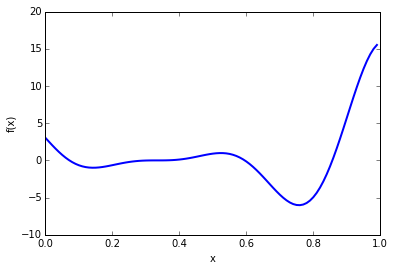

In [11]:
f_true.plot(bounds)

As we did in Section 3, we need to create the GPyOpt object that will run the optimization. We specify the function, the boundaries and we add the type of acquisition function to use. The acquisition parameter (acquistion_par in the funcion input) is the $\psi$ parameter in Section 4.2.

In [12]:
# Creates GPyOpt object with the model and anquisition fucntion
seed(1234)
myBopt = GPyOpt.methods.BayesianOptimization(f=f_sim.f,            # function to optimize       
                                             bounds=bounds,        # box-constrains of the problem
                                             acquisition='EI',     # Selects the Expected improvement
                                             acquisition_par = 0)  # psi parameter is set to zero

Now we want to run the optimization. Apart from the number of iterations you can select 
how do you want to optimize the acquisition function. You can run a number of local optimizers (acqu_optimize_restart) at random or in grid (acqu_optimize_method).     

In [13]:
# Run the optimization
max_iter = 15  # evaluation budget

myBopt.run_optimization(max_iter,                                  # Number of iterations
                          acqu_optimize_method = 'fast_random',    # method to optimize the acq. function
                          acqu_optimize_restarts = 30,             # number of local optimizers 
                          eps=10e-6)                     # secondary stop criteria  

*Optimization completed:
   -Maximum number of iterations reached.


1

When the optimization is done you should receive a message describing if the method converged or if the maximum number of iterations was reached. In one dimensional examples, you can see the result of the optimization as follows.

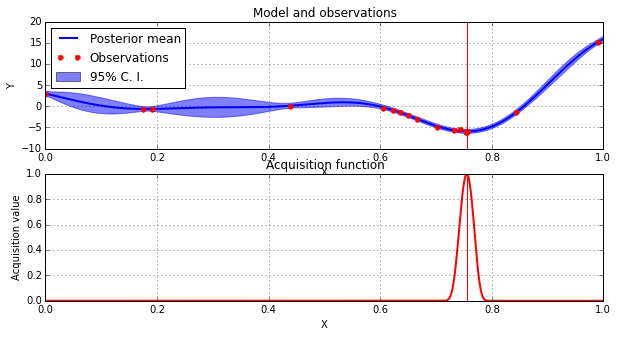

In [14]:
myBopt.plot_acquisition()

In problems of any dimension three evaluations plots are available.

* The distance between the last two observations.

* The value of $f$ at the best location previous to each iteration.

* The predicted standard deviation of each new location.

To see these plots just run the following cell.

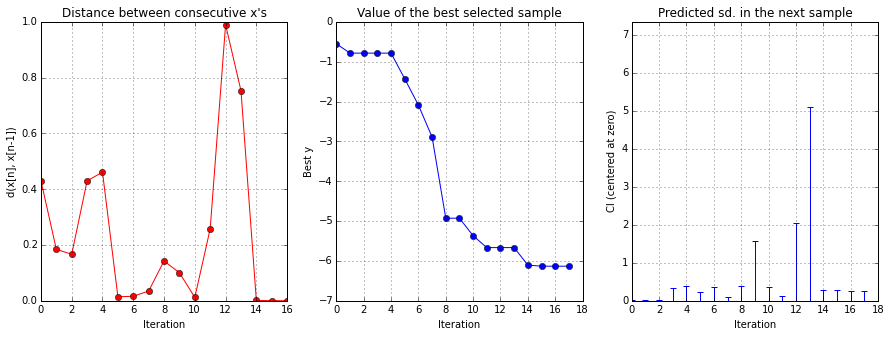

In [15]:
myBopt.plot_convergence()

Now let's make a video to track what the algorithm is doing in each iteration. Let's use the LCB in this case with parameter equal to 3.

In [26]:
# starts the optimization 
seed(1)
iterBopt = GPyOpt.methods.BayesianOptimization(f=f_sim.f,
                                               numdata_initial_design = 2 ,
                                             bounds=bounds,
                                             acquisition='LCB',
                                             acquisition_par = 2)

In [27]:
# model set-up
iterBopt.model.kern.rbf.variance.constrain_fixed(2)
iterBopt.model.Gaussian_noise.constrain_bounded(0.01,0.5)   # fixed for visualization purposes

*Optimization completed:
   -Maximum number of iterations reached.


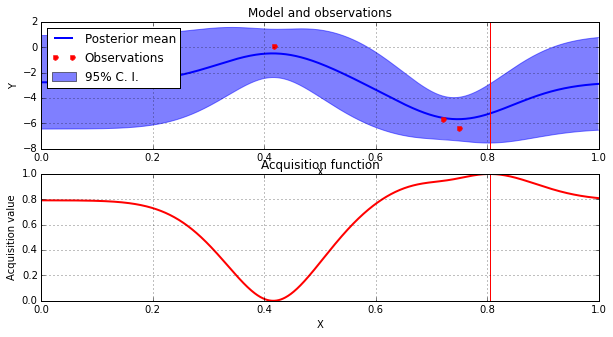

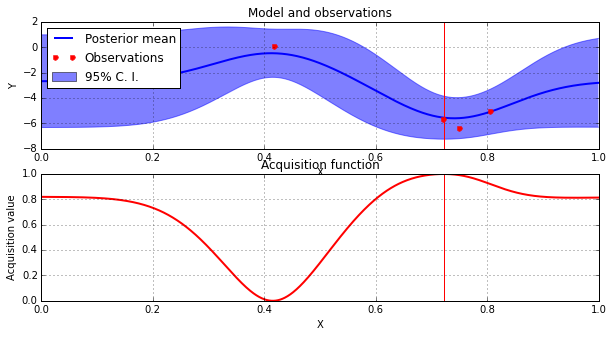

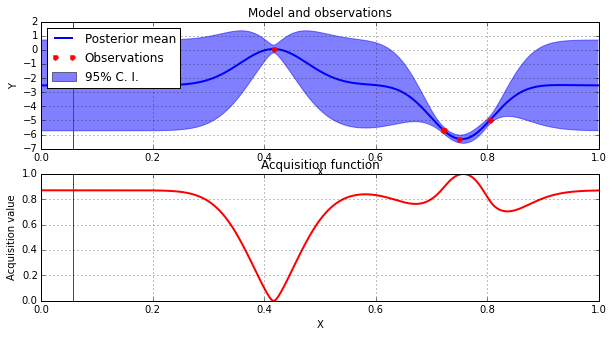

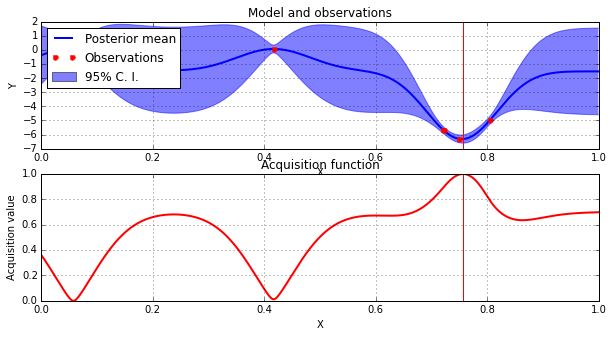

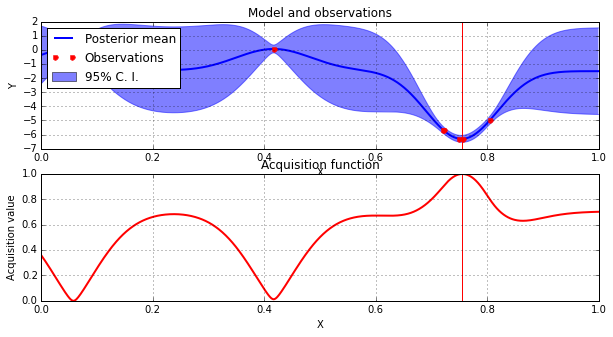

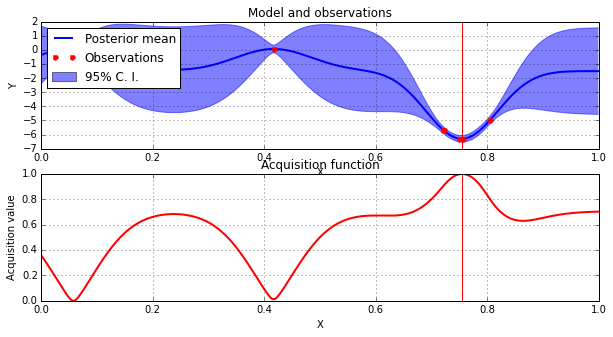

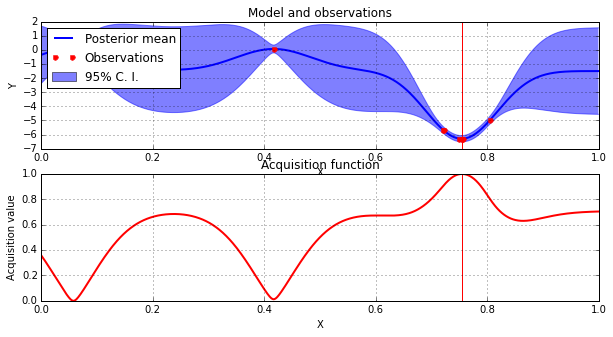

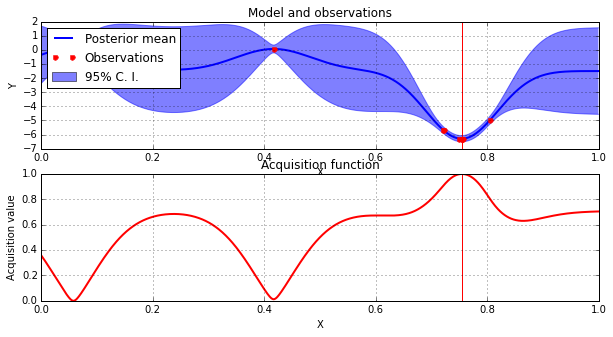

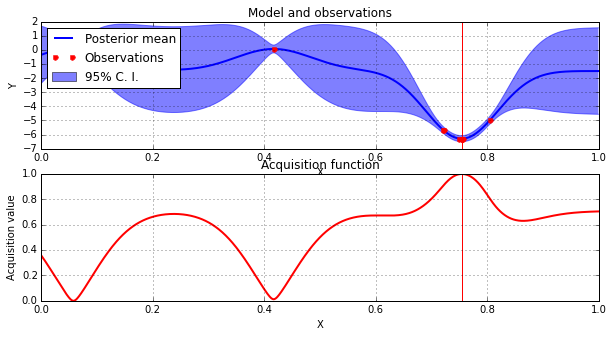

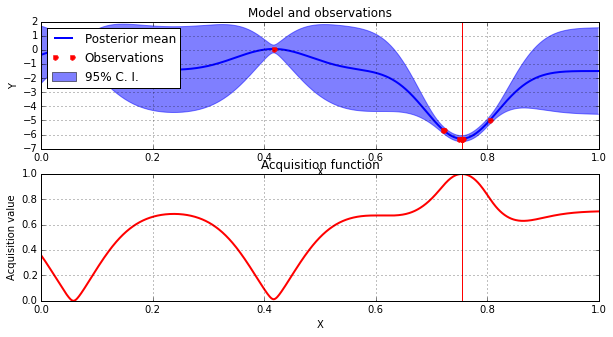

In [28]:
from IPython.display import clear_output
N_iter = 10

for i in range(N_iter):
    clear_output()
    
    seed(123)
    iterBopt.run_optimization(max_iter=1, 
                          acqu_optimize_method = 'fast_random',   # method to optimize the acquisition function
                          acqu_optimize_restarts = 30,          # number of local optimizers 
                          eps=10e-6)                   # secondary stop criteria
    iterBopt.plot_acquisition('iteration%.03i.png' % (i + 1))


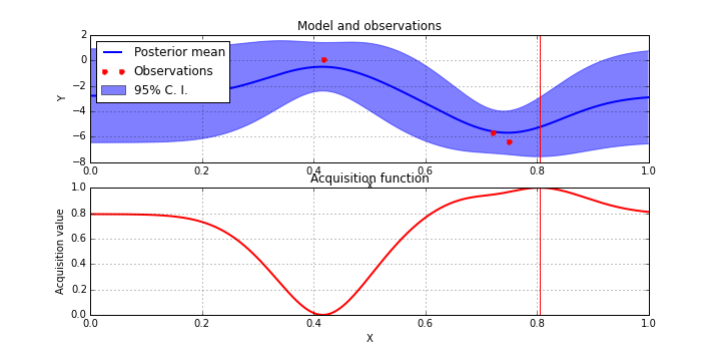
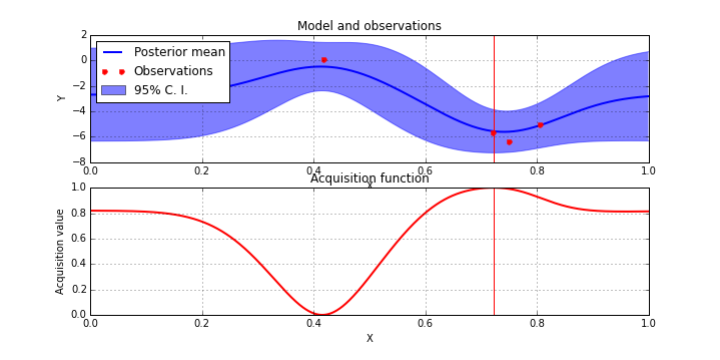
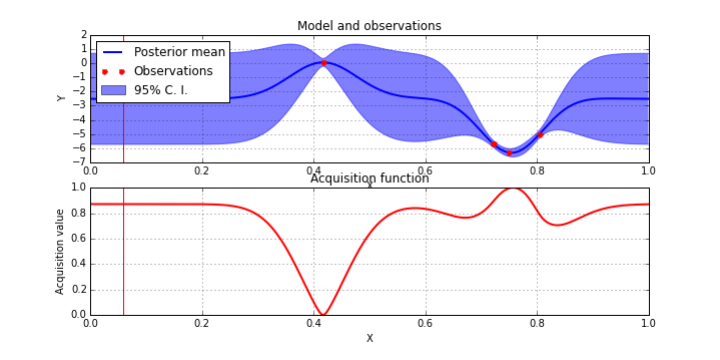
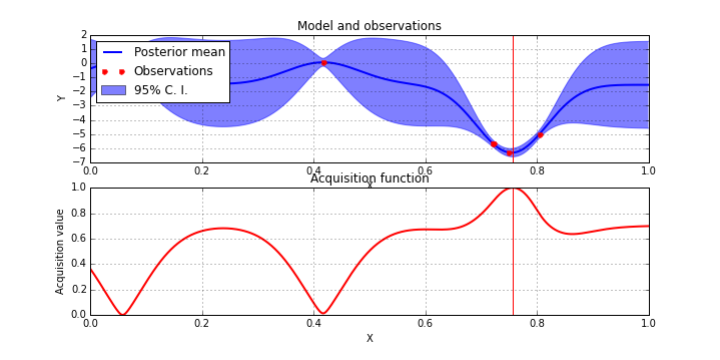
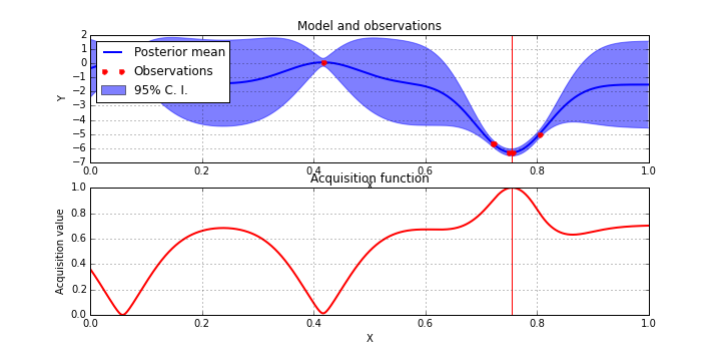
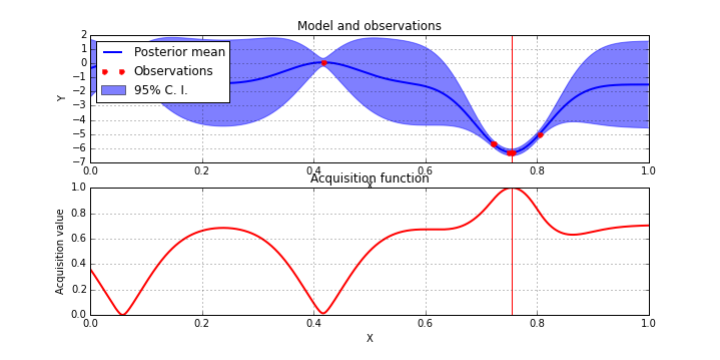
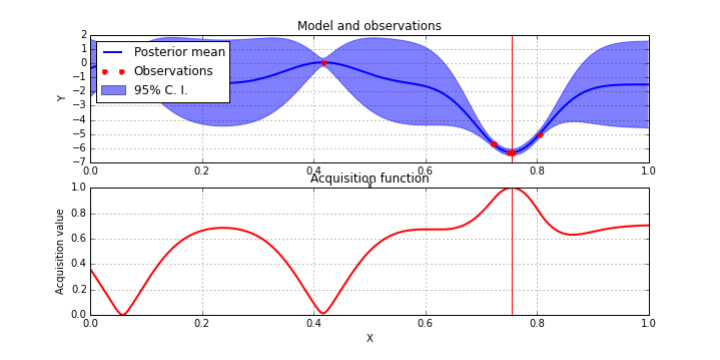
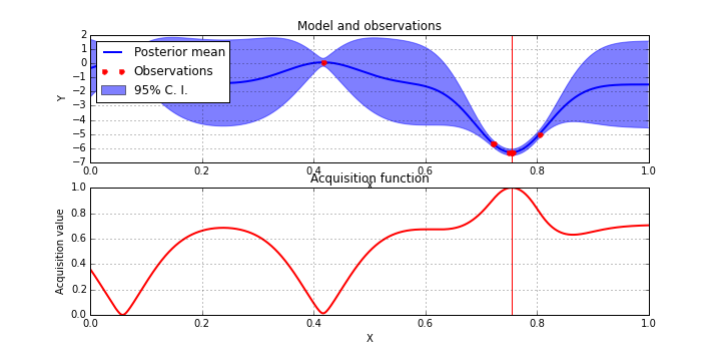
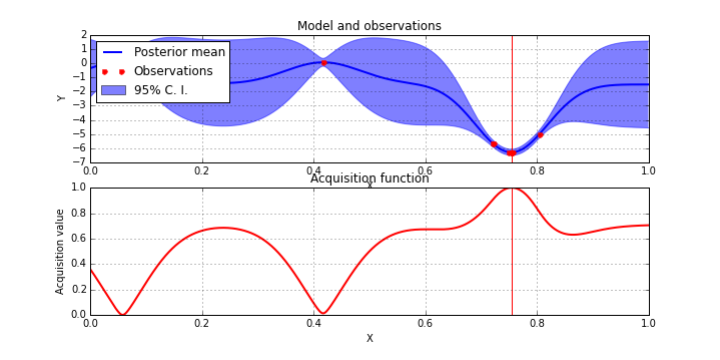
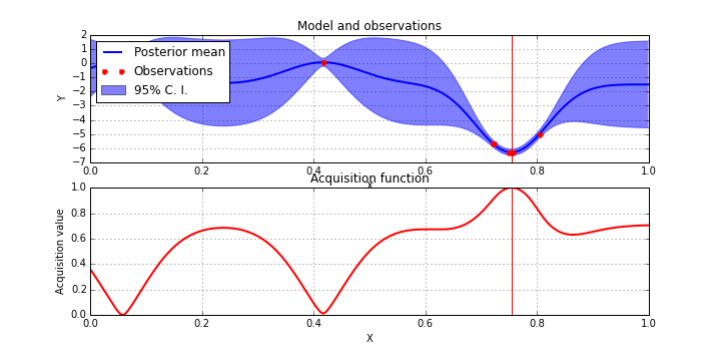

In [29]:
# Import JSAnimation 
from JSAnimation import IPython_display, HTMLWriter
from matplotlib import animation
from PIL import Image
import glob

# Choose location of files to use
filenames=sorted(glob.glob('iteration*.png'))

#Create figure
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
im = plt.imshow(Image.open(filenames[0]))

# Create initializatio function and animation
def init():
    im.set_data(Image.open(filenames[0]))
    return im,

def animate(i):
    image=Image.open(filenames[i])
    im.set_data(image)
    return im,

nframes = N_iter    # we create as many frames as iterations in the BO loop.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=nframes, interval=1000, blit=True)

# Show animation in ipython notebook
anim

## 6. Two dimensional example

Next, we try a 2-dimensional example. In this case we minimize the use the Six-hump camel function 

$$f(x_1,x_2) = \left(4-2.1x_1^2 = \frac{x_1^4}{3} \right)x_1^2 + x_1x_2 + (-4 +4x_2^2)x_2^2,$$

in $[-3,3]\times [-2,2]$. This functions has two global minimum, at $(0.0898,-0.7126)$ and $(-0.0898,0.7126)$. As in the previous case we create the function, which is already in GPyOpt.

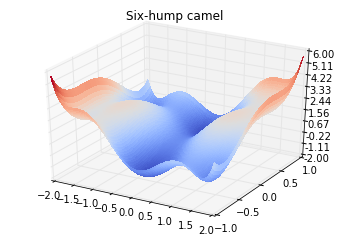

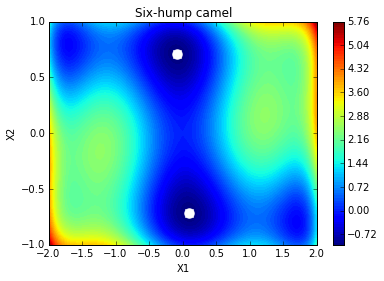

In [30]:
# create the object function
f_true = GPyOpt.fmodels.experiments2d.sixhumpcamel()
f_sim = GPyOpt.fmodels.experiments2d.sixhumpcamel(sd = 0.1)
f_true.plot()
bounds = f_true.bounds

We create the GPyOpt object. In this case we use the Lower Confidence bound acquisition function to solve the problem.

In [31]:
# Creates three identical objects that we will later use to compare the optimization strategies 
myBopt2D = GPyOpt.methods.BayesianOptimization(f_sim.f,
                                              bounds=bounds,
                                              acquisition='LCB',   # Lower confidence bound method 
                                              acquisition_par = 2, # Set parameter psi=2 
                                              normalize = True)    # Normalize the acquisition funtction

 We run the optimization for 40 iterations and show the evaluation plot and the acquisition function.

In [32]:
# runs the optimization for the three methods
max_iter = 40

myBopt2D.run_optimization(max_iter,
                          acqu_optimize_method = 'fast_brute',  # lattice of initial points for local optimizers
                          acqu_optimize_restarts = 10,     # partition per dimension 
                          eps=1e-10)             # stop criteria (distance between consecutive observations) 

*Optimization completed:
   -Maximum number of iterations reached.


1

Finally, we plot the acquisition function and the convergence plot.

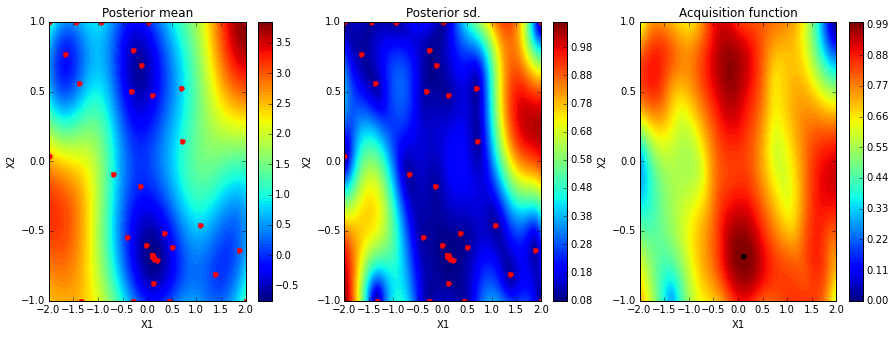

In [33]:
myBopt2D.plot_acquisition() 

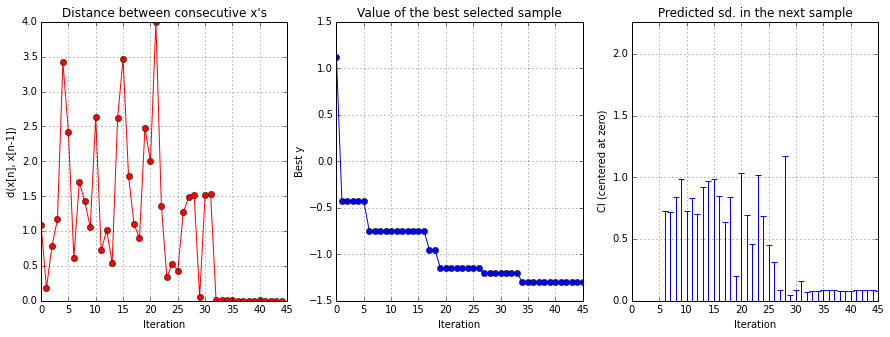

In [34]:
myBopt2D.plot_convergence()